# Foreword

The paper we're referring to in this document: "Quantum querying based on multicontrolled Toffoli gates for causal Feynman loop configurations and directed acyclic graphs" by Selomit Ramirez-Uribe, Andres E. Renteria-Olivo and German Rodrigo

NOTE: "It is worth mentioning that the most effective implementation for the majority of the multiloop topologies analysed is achieved with a single iteration" -> This implementation/algorithm is specifically for 'single iteration-topologies'

Disclaimer: This was the first PoC for a weighting algorithm I made, subsequent versions (with slightly different goals) have a much nicer implementation utilizing H-boxes instead of black triangles

# Implementation

In [1]:
import pyzx as zx
from pyzx.basicrules import fuse
from fractions import Fraction
import numpy as np
import sympy as sp
from collections import defaultdict
import matplotlib.pyplot as plt
import sys

np.set_printoptions(threshold=np.inf) # print the whole matrix

In [ ]:
# NOTE: Comment from future me: In retrospect, this is very not ideal, it would've been much nicer to use H-boxes (I used it for another project and it was much easier)

master_0_phase = Fraction(1,3) # represents 0, ...
master_pi_phase = Fraction(2,3) # represents pi, ...
star_phase = Fraction(5,3) # represents triangle and NOT, ...
# ... which makes searching easier

In [3]:
Z = zx.VertexType.Z
X = zx.VertexType.X
B = zx.VertexType.BOUNDARY
W_INP = zx.VertexType.W_INPUT
W_OUT = zx.VertexType.W_OUTPUT
SE = zx.EdgeType.SIMPLE
HE = zx.EdgeType.HADAMARD

In [4]:
draw_scale_default = 30

In [5]:
def are_complimentary_master_phases(phase1, phase2):
    if phase1 in [0, master_0_phase]:
        if phase2 in [1, master_pi_phase]:
            return True
        return False
    
    if phase1 in [1, master_pi_phase]:
        if phase2 in [0, master_0_phase]:
            return True
        return False

In [6]:
def nice_print(str, conditional=True):
    if conditional:
        print(str)

# like zx.draw but with my favorite settings already set
def nice_draw(g, conditional=True, labels=True, scale=draw_scale_default):
    if not conditional:
        return
    
    exact_string = str(g.scalar).split(" = ")[1]
    numeric_string = str(g.scalar.to_number())
    print("\t" + exact_string + " ≈ " + numeric_string)

    zx.draw(g, labels=labels, scale=scale)

In [7]:
def to_pure_matrix(matrix):
    # get rid of floating point error
    # change -0.0 to 0.0
    return np.around(matrix, 10) + 0.

In [8]:
# checks whether arr1 ≈ x*arr2 for integer x
def allclose_up_to_scalar(arr1, arr2, rtol=1e-05, atol=1e-08):
    if arr1.shape != arr2.shape:
        return False
    
    scalar = None
    for i in range(arr1.size):
        if arr1[i] != 0:
            if scalar is None:
                scalar = arr2[i] / arr1[i]
            elif not np.isclose(arr2[i], arr1[i] * scalar, rtol=rtol, atol=atol):
                return False
        elif arr2[i] != 0:
            return False
    
    return True

# converts all the diagrams in cliffs and non_cliffs list to statevector representation
# and then sums all of them up and compares result with orig_statevec
def check_decomp(qcirc, orig_statevec, cliffs, non_cliffs):
    final_statevec = np.zeros(2**qcirc.e_cnt, dtype=complex)

    for cliff in cliffs:
        cliff = cliff.copy()

        qcirc.revert_master_phases(cliff)
        zx.full_reduce(cliff)

        statevec = to_pure_matrix(cliff.to_matrix()).flatten()
        final_statevec += statevec
    
    for non_cliff in non_cliffs:
        non_cliff = non_cliff.copy()

        qcirc.revert_star_placeholder(non_cliff)
        qcirc.revert_master_phases(non_cliff)
        zx.full_reduce(non_cliff)

        statevec = to_pure_matrix(non_cliff.to_matrix()).flatten()
        final_statevec += statevec

    final_statevec = final_statevec / np.linalg.norm(final_statevec) # necessary, orig_statevec was also normalized

    print("orig_statevec:")
    print(orig_statevec)
    print("final_statevec:")
    print(final_statevec)
    print("-->")
    # sanity check
    sum = 0
    for element in final_statevec:
        sum += np.abs(element) ** 2
    print("sum:", sum)
    print("allclose_up_to_scalar:", allclose_up_to_scalar(orig_statevec, final_statevec))
    print("allclose:", np.allclose(orig_statevec, final_statevec))

    return np.allclose(orig_statevec, final_statevec)

In [9]:
# called by recursive decomp algorithm when discovering a disconected Z-Star-Z configuration, which
# is easy to convert to a scalar (that is automatically changed in g)
def convert_z_isolated_star_to_scalar(g, v1, star, v2):
    A = sp.Matrix([[1, 1], [1, 0]]) # star matrix

    def get_state_vec_components(v):
        if g.type(v) == Z and (g.phase(v) == 0 or g.phase(v) == master_0_phase):
            return sp.Matrix([1, 1])
        elif g.type(v) == Z and (g.phase(v) == 1 or g.phase(v) == master_pi_phase):
            return sp.Matrix([1, -1])
        else:
            print("INVALID SCALAR PASSED TO FUNCTION")
            sys.exit(0)
    
    x = get_state_vec_components(v1)
    y = get_state_vec_components(v2)

    Ay = A * y  # matrix-vector product A * y
    result = x.dot(Ay)  # inner product <x | (A * y)>
    
    g.remove_vertex(v1)
    g.remove_vertex(star)
    g.remove_vertex(v2)

    if result == 3:
        g.scalar.add_float(3)
    elif result == 1:
        pass
    elif result == -1:
        g.scalar.add_phase(Fraction(1,1))
    else:
        print("IMPOSSIBLE (?) SCALAR ACHIEVED")
        sys.exit(0)

# pushes as normal, but also fuses spiders of same color and is considerate
# of placeholders. returns same vertex if can't be pushed further, returns
# list of newly generated vertices otherwise
def generic_state_push(g, v, leave_scalar_unchanged=False, consider_had_edge=False):
    vtype = g.type(v)
    vphase = g.phase(v)

    if not (g.vertex_degree(v) == 1 and (vphase in [0,1, master_0_phase, master_pi_phase]) and (vtype in [Z,X])):
        return [v]

    nv = next(iter(g.neighbors(v)))
    nvtype = g.type(nv)

    def apply_color_change():
        if vtype == Z:
            g.set_type(v, X)
        elif vtype == X:
            g.set_type(v, Z)
        
        nv_nv = None
        for n in g.neighbors(nv):
            if n != v:
                nv_nv = n
                break

        nv_nv_nv = None
        for n in g.neighbors(nv_nv):
            if n != nv:
                nv_nv_nv = n
                break

        g.remove_vertex(nv)
        g.remove_vertex(nv_nv)
        g.add_edge((v, nv_nv_nv))

        return nv_nv_nv

    if consider_had_edge:
        if "placeholder" in g.vdata_keys(nv):
            if g.vdata(nv, "placeholder") == "had_edge_side_vertex":
                nv = apply_color_change()
                nvtype = g.type(nv)
                vtype = g.type(v)

    if not nvtype in [Z,X]:
        return [v]
    
    # TODO: Remove vertex and adjust scalar if necessary or even delete diagram (e.g. by returning [0] -> check after function call)
    if g.vertex_degree(nv) == 1: # scalar
        return [v]

    if g.phase(nv) == star_phase:
        neighbor_of_nv = list(g.neighbors(nv))
        neighbor_of_nv.remove(v)

        if len(neighbor_of_nv) > 1:
            print("DIAGRAM IS INVALID! CAN'T HAVE MULTIPLE EDGES CONNECTED TO A STAR SPIDER!")
            sys.exit(0)

        neighbor_of_nv = neighbor_of_nv[0]
        
        # TODO
        if g.type(v) != X:
            if g.vertex_degree(neighbor_of_nv) > 1:
                # print("BEFORE: ------------------------------------------------------------------------------------------------------------------------------------------")
                # nice_draw(g)
                if vphase != master_pi_phase:
                    return [v]

                new_v = g.add_vertex(X, g.qubit(nv), g.row(nv), phase=Fraction(1,1))
                g.remove_vertex(v)
                g.remove_vertex(nv)
                g.add_edge((new_v, neighbor_of_nv))
                g.scalar.add_power(-1)
                
                # print("AFTER: ------------------------------------------------------------------------------------------------------------------------------------------")
                # nice_draw(g)
                return [new_v]

            # TODO: Manually determine all scalars so it doesn't have to decompose it in case it's a mster node
            elif g.type(neighbor_of_nv) == X:
                return [neighbor_of_nv]
            else:
                orig_v = v
                convert_z_isolated_star_to_scalar(g, v, nv, neighbor_of_nv) # v gets removed
                return [orig_v]

        master_used = False
        if vphase == master_0_phase:
            g.set_phase(v, 0)
            vphase = 0
            master_used = True
        elif vphase == master_pi_phase:
            g.set_phase(v, Fraction(1,1))
            vphase = 1
            master_used = True

        if vphase == 0:
            g.scalar.add_power(1)
            g.set_type(v, Z)
        else:
            g.set_phase(v, 0)
        
        new_v = g.add_vertex(g.type(v), g.qubit(nv), g.row(nv), phase=g.phase(v))

        if master_used and vphase == 0:
            g.set_phase(new_v, master_0_phase)
        elif master_used and vphase == 1:
            g.set_phase(new_v, master_pi_phase)

        g.remove_vertex(v)
        g.remove_vertex(nv)
        g.add_edge((new_v, neighbor_of_nv))

        return [new_v]

    if vtype == nvtype:
        master_used = False
        if vphase == master_0_phase:
            g.set_phase(v, 0)
            master_used = True
        elif vphase == master_pi_phase:
            g.set_phase(v, Fraction(1,1))
            master_used = True
        if g.phase(nv) == master_0_phase:
            g.set_phase(nv, 0)
            master_used = True
        elif g.phase(nv) == master_pi_phase:
            g.set_phase(nv, Fraction(1,1))
            master_used = True

        fuse(g, nv, v)

        new_v = g.add_vertex(g.type(nv), g.qubit(nv), g.row(nv), phase=g.phase(nv))

        # rare 'bug', sometimes new_v same as v
        if new_v == v:
            orig_new_v = new_v
            new_v = g.add_vertex(g.type(nv), g.qubit(nv), g.row(nv), phase=g.phase(nv))
            g.remove_vertex(orig_new_v)

        if master_used and g.phase(nv) == 0:
            g.set_phase(new_v, master_0_phase)
        elif master_used and g.phase(nv) == 1:
            g.set_phase(new_v, master_pi_phase)

        neighbors_of_nv = list(g.neighbors(nv))
        for neighbor in neighbors_of_nv:
            g.add_edge((new_v, neighbor))
        g.remove_vertex(nv)

        if g.vertex_degree(new_v) == 1:
            return [new_v]
        
        return [v]
    
    new_v = []

    neighbors_of_nv = list(g.neighbors(nv))
    neighbors_of_nv.remove(v)

    # \frac{e^{i*a*alpha}}{\sqrt{2}^{n-1}}, v has phase a*pi, alpha is nvphase
    a = 1 if vphase in [1, master_pi_phase] else 0
    nvphase = g.phase(nv)
    if nvphase in [0, 1]:
        alpha = nvphase
    elif nvphase == master_0_phase:
        alpha = 0
    elif nvphase == master_pi_phase:
        alpha = Fraction(1,1)
    else:
        print("INVALID NEIGHBOR OF PUSHING TARGET")
        sys.exit(0)
    n = len(neighbors_of_nv)
    
    if not leave_scalar_unchanged:
        g.scalar.add_phase(a*alpha)
        g.scalar.add_power(-(n-1))

    for neighbor in neighbors_of_nv:
        new_v.append(g.add_vertex(vtype, g.qubit(nv), g.row(nv), phase=vphase))
        g.add_edge((new_v[-1], neighbor))
    g.remove_vertex(v)
    g.remove_vertex(nv)
    
    return new_v

In [10]:
class QCirc:
    # prepares init_subgraphs (IS) with states according to size of E, A and OUT register
    def __init__(self, e_cnt, a_cnt, out_cnt):
        # initially, there is only one graph, which is split into "subgraphs"
        self.init_subgraphs = []

        # afterwards, there are lots of diagrams - whilst not fully decomposed, they are in non_cliffs, once they are, they go into cliffs
        self.non_cliffs = []
        self.cliffs = []

        # can be set for debugging purposes (the statevector of the original circuit with effects applied)
        # should not be used for complex topologies since this is obviously very inefficient (otherwise no need for this whole algorithm)
        self.orig_statevec = None

        # can be set for debugging/benchmarking purposes
        self.t_repr_graph = None

        self.e_cnt = e_cnt
        self.a_cnt = a_cnt
        self.out_cnt = out_cnt

        cur = zx.Graph()

        for i in range(self.e_cnt):
            z = cur.add_vertex(Z, qubit=i, row=0)
            end = cur.add_vertex(B, qubit=i, row=1)
            cur.add_edge((z, end))

        for i in range(self.e_cnt, self.e_cnt+self.a_cnt):
            x = cur.add_vertex(X, qubit=i, row=0, phase=Fraction(1,1))
            end = cur.add_vertex(B, qubit=i, row=1)
            cur.add_edge((x, end))
        
        for i in range(self.e_cnt+self.a_cnt, self.e_cnt+self.a_cnt+self.out_cnt):
            z = cur.add_vertex(Z, qubit=i, row=0, phase=Fraction(1,1))
            end = cur.add_vertex(B, qubit=i, row=1)
            cur.add_edge((z, end))
        
        cur.auto_detect_io()
        self.init_subgraphs.append(cur)

    # can be set for debugging purposes (the statevector of the original circuit with effects applied)
    # should not be called for complex topologies since this is obviously very inefficient (otherwise no need for this whole algorithm)
    def set_orig_statevec(self):
        orig_qcirc = self.get_merged_IS().copy()
        self.apply_effect_scalar_invariant(orig_qcirc, "/"*self.e_cnt + "1"*self.a_cnt + "-"*self.out_cnt)
        self.revert_master_phases(orig_qcirc)

        orig_statevec = to_pure_matrix(orig_qcirc.to_matrix()).flatten()
        orig_statevec = orig_statevec / np.linalg.norm(orig_statevec)

        self.orig_statevec = orig_statevec

    ### Following section contain functions that work with the init_subgraphs (IS) representation ###

    # returns composition of all elements in IS into one graph
    def get_merged_IS(self):
        whole_graph = self.init_subgraphs[0]
        for i in range(1, len(self.init_subgraphs)):
            whole_graph = whole_graph + self.init_subgraphs[i]
        
        return whole_graph

    # replaces all triangles with equivalent diagram consisting of T gates
    # not used for this algorithm, but may be used when benchmarking against other algorithms, which require use of T-gates instead of triangles
    def get_t_gate_repr(self):
        g = self.get_merged_IS()

        vertices_to_be_deleted = []
        for v in list(g.vertices()):              
            if v in vertices_to_be_deleted:
                continue
            
            if g.type(v) == W_INP:
                neighbors = g.neighbors(v)

                # this assumes there will never be a triangle connected to something else than a NOT-gate (which is always the case for toffoli gates)
                w_out = None
                x_pi = None
                for neighbor in neighbors:
                    if g.type(neighbor) == W_OUT:
                        w_out = neighbor
                        continue
                    x_pi = neighbor
                
                w_out_neighbors = [neighbor for neighbor in g.neighbors(w_out) if neighbor != v]
                x_pi_neighbor = [neighbor for neighbor in g.neighbors(x_pi) if neighbor != v][0]

                # triangle has a state still attached, remove it
                w_out_neighbor = None
                for j in range(len(w_out_neighbors)):
                    if len(list(g.neighbors(w_out_neighbors[j]))) == 1:
                        vertices_to_be_deleted.append(w_out_neighbors[j])
                    else:
                        w_out_neighbor = w_out_neighbors[j]

                vertices_to_be_deleted.append(v)
                vertices_to_be_deleted.append(w_out)
                vertices_to_be_deleted.append(x_pi)

                new_qubit_pos = g.qubit(x_pi)
                new_row_pos = g.row(x_pi)

                x1 = g.add_vertex(X, qubit=new_qubit_pos, row=new_row_pos-0.5)
                z1 = g.add_vertex(Z, qubit=new_qubit_pos-0.5, row=new_row_pos, phase=Fraction(-1,4))
                z2 = g.add_vertex(Z, qubit=new_qubit_pos+0.5, row=new_row_pos, phase=Fraction(1,4))
                x2 = g.add_vertex(X, qubit=new_qubit_pos-0.5, row=new_row_pos+0.5)
                x3 = g.add_vertex(X, qubit=new_qubit_pos+0.5, row=new_row_pos+0.5)
                z3 = g.add_vertex(Z, qubit=new_qubit_pos-1, row=new_row_pos+0.5, phase=Fraction(-1,4))
                z4 = g.add_vertex(Z, qubit=new_qubit_pos+1, row=new_row_pos+0.5, phase=Fraction(1,4))
                z5 = g.add_vertex(Z, qubit=new_qubit_pos, row=new_row_pos+1)
                x_not = g.add_vertex(X, qubit=new_qubit_pos, row=new_row_pos+1.5, phase=Fraction(1,1))

                g.add_edge((x_pi_neighbor, x1))
                g.add_edge((x1, z1))
                g.add_edge((z1, x2))
                g.add_edge((x2, z3))
                g.add_edge((x2, z5))
                g.add_edge((x1, z2))
                g.add_edge((z2, x3))
                g.add_edge((x3, z4))
                g.add_edge((x3, z5))
                g.add_edge((z5, x_not))
                g.add_edge((x_not, w_out_neighbor))

                g.scalar.add_power(1)

        for v in vertices_to_be_deleted:
            g.remove_vertex(v)

        return g

    # store the T-gate representation graph for later use (if needed for benchmarking)
    def set_t_gate_repr_graph(self):
        self.t_repr_graph = self.get_t_gate_repr()

    # adds new element to IS, consisting of NOT gates at qubit positions specified
    # by idx_list, identities everywhere else
    def add_not_gates_IS(self, idx_list):
        cur = zx.Graph()

        for i in range(self.e_cnt+self.a_cnt+self.out_cnt):
            if i in idx_list:
                start = cur.add_vertex(B, qubit=i, row=0)
                not_gate = cur.add_vertex(X, qubit=i, row=1, phase=Fraction(1,1))
                end = cur.add_vertex(B, qubit=i, row=2)
                cur.add_edge((start, not_gate))
                cur.add_edge((not_gate, end))
            else:
                start = cur.add_vertex(B, qubit=i, row=0)
                end = cur.add_vertex(B, qubit=i, row=2)
                cur.add_edge((start, end))
        
        cur.auto_detect_io()
        self.init_subgraphs.append(cur)
    
    # adds new element to IS, namely a multi-controlled toffoli gate (control qubits specified by ctrl_idx_list, target qubit by targ_idx)
    # if pi_inside == False, then one of the two X Pi spiders making up the ZX-Representation will be pushed out onto main "qubit wires" 
    # assumes targ_idx > any(ctrl_idx_list) (aka below them)
    def add_toffoli_gates_IS(self, ctrl_idx_list, targ_idx, pi_inside=True):
        if not pi_inside:
            self.add_not_gates_IS(ctrl_idx_list)

        cur = zx.Graph()

        z_verts = [] # notice this will be sorted from smallest to biggest
        x_vert = None

        for i in range(self.e_cnt+self.a_cnt+self.out_cnt):
            if i in ctrl_idx_list:
                start = cur.add_vertex(B, qubit=i, row=0)
                z = cur.add_vertex(Z, qubit=i, row=1)
                z_verts.append(z)
                end = cur.add_vertex(B, qubit=i, row=3)
                cur.add_edge((start, z))
                cur.add_edge((z, end))
            elif i == targ_idx:
                start = cur.add_vertex(B, qubit=i, row=0)
                x = cur.add_vertex(X, qubit=i, row=1)
                x_vert = x
                end = cur.add_vertex(B, qubit=i, row=3)
                cur.add_edge((start, x))
                cur.add_edge((x, end))
            else:
                start = cur.add_vertex(B, qubit=i, row=0)
                end = cur.add_vertex(B, qubit=i, row=3)
                cur.add_edge((start, end))
        
        targ_shift = cur.add_vertex(Z, qubit=-0.5, row=3, phase=Fraction(1,1))
        not_shift = cur.add_vertex(X, qubit=-1, row=3, phase=Fraction(1,1))
        b_shift = cur.add_vertex(B, qubit=-1, row=3.5)
        cur.add_edge((x_vert, targ_shift))
        cur.add_edge((targ_shift, not_shift))
        cur.add_edge((not_shift, b_shift))

        for i, z_vert in enumerate(z_verts):
            if pi_inside:
                x_pi = cur.add_vertex(X, qubit=-len(z_verts)+i-1, row=2.5, phase=Fraction(1,1))
                not_shift = cur.add_vertex(X, qubit=-len(z_verts)+i-1, row=3, phase=Fraction(1,1))
                b_shift = cur.add_vertex(B, qubit=-len(z_verts)+i-1, row=3.5)
                cur.add_edge((z_vert, x_pi))
                cur.add_edge((x_pi, not_shift))
                cur.add_edge((not_shift, b_shift))
            else:
                not_shift = cur.add_vertex(X, qubit=-len(z_verts)+i-1, row=3, phase=Fraction(1,1))
                b_shift = cur.add_vertex(B, qubit=-len(z_verts)+i-1, row=3.5)
                cur.add_edge((z_vert, not_shift))
                cur.add_edge((not_shift, b_shift))

        triangle = zx.generate.spider("W",1,2) + (zx.generate.spider("Z", 1, 0) @ zx.generate.identity(1))
        # hardcoded positions for triangle (by trial-and-error)
        q_pos_list = [0, 0, 0, -0.25, 0]
        q_pos_list = [-(len(z_verts)+1)+x for x in q_pos_list]
        r_pos_list = [0.2, 0.35, 0, 0.7, 1]
        for i, v in enumerate(triangle.vertices()):
            triangle.set_position(v, q_pos_list[i], r_pos_list[i])
        triangles = triangle
        
        for i in range(len(z_verts)):
            triangle = zx.generate.spider("W",1,2) + (zx.generate.spider("Z", 1, 0) @ zx.generate.identity(1))
            # hardcoded positions for triangle (by trial-and-error)
            q_pos_list = [0, 0, 0, -0.25, 0]
            r_pos_list = [0.2, 0.35, 0, 0.7, 1]
            for i, v in enumerate(triangle.vertices()):
                triangle.set_position(v, q_pos_list[i], r_pos_list[i])
            
            triangles = triangles @ triangle
        
        for i in range(self.e_cnt+self.a_cnt+self.out_cnt):
            triangles = triangles @ zx.generate.identity(1)

        after_triangle = zx.Graph()
        mid_idx = len(ctrl_idx_list + [targ_idx])/2
        mid_idx = round(mid_idx * 2) / 2 # round to nearest 0.5
        if int(mid_idx) == mid_idx: # add 0.5 if ending in .0
            mid_idx += 0.5
        master = after_triangle.add_vertex(Z, qubit=-mid_idx, row=1, phase=master_pi_phase)
        final_not = after_triangle.add_vertex(X, qubit=-1, row=1, phase=Fraction(1,1))

        for i in range(len(z_verts)+1):
            bound = after_triangle.add_vertex(B, qubit=-(len(z_verts)+1)+i, row=0)
            if i == len(z_verts):
                after_triangle.add_edge((bound, final_not))
                after_triangle.add_edge((final_not, master))
            else:
                after_triangle.add_edge((bound, master))
        
        for i in range(self.e_cnt+self.a_cnt+self.out_cnt):
            after_triangle = after_triangle @ zx.generate.identity(1)
        
        cur.auto_detect_io()
        triangles.auto_detect_io()
        after_triangle.auto_detect_io()
        cur = cur + triangles + after_triangle
        cur.auto_detect_io()
        self.init_subgraphs.append(cur)

        if not pi_inside:
            self.add_not_gates_IS(ctrl_idx_list)

    # adds new element to IS, namely the Grover diffusion operator U_s=2|s><s|-I
    def apply_diffusion_operator_IS(self):
        left = zx.Graph()

        for i in range(self.e_cnt):
            if i != self.e_cnt - 1:
                start = left.add_vertex(B, qubit=i, row=0)
                z1 = left.add_vertex(Z, qubit=i, row=1)
                z2 = left.add_vertex(Z, qubit=i, row=2)
                x_pi = left.add_vertex(X, qubit=i, row=3, phase=Fraction(1,1))
                end = left.add_vertex(B, qubit=i, row=4)
                left.add_edge((start, z1))
                left.add_edge((z1, z2), HE)
                left.add_edge((z2, x_pi))
                left.add_edge((x_pi, end))

                left.set_vdata(z1, "placeholder", "had_edge_side_vertex")
                left.set_vdata(z2, "placeholder", "had_edge_side_vertex")
            else:
                start = left.add_vertex(B, qubit=i, row=0)
                z_pi = left.add_vertex(Z, qubit=i, row=2, phase=Fraction(1,1))
                end = left.add_vertex(B, qubit=i, row=3)
                left.add_edge((start, z_pi))
                left.add_edge((z_pi, end))
        
        for i in range(self.e_cnt, self.e_cnt + self.a_cnt + self.out_cnt):
            start = left.add_vertex(B, qubit=i, row=0)
            end = left.add_vertex(B, qubit=i, row=3)
            left.add_edge((start, end))

        # TODO: actually this doesn't change anything in the end
        # doesn't matter which of the subgraphs gets the new scalar, just one of them, since merged afterwards anyways
        left.scalar.add_power(2+(self.e_cnt-1))

        left.auto_detect_io()
        self.init_subgraphs.append(left)

        self.add_toffoli_gates_IS([i for i in range(self.e_cnt-1)], self.e_cnt-1)

        right = left.adjoint()
        self.init_subgraphs.append(right)

    # commutes a column of NOT gates to the left, if there are obstructions in the way, pushing may change toffoli structure
    # both x_pi and toffoli graph have to be in initial default form, don't use after further simplifications!
    # not sure about pi_inside=True version
    def x_pi_commute_to_left_IS(self, x_pi_subgraph_idx):
        if x_pi_subgraph_idx <= 1:
            return False
        
        not_qubits = []
        for v in self.init_subgraphs[x_pi_subgraph_idx].vertices():
            if self.init_subgraphs[x_pi_subgraph_idx].type(v) != X or self.init_subgraphs[x_pi_subgraph_idx].phase(v) != 1:
                continue

            not_qubits.append(self.init_subgraphs[x_pi_subgraph_idx].qubit(v))

        self.init_subgraphs[x_pi_subgraph_idx-1], self.init_subgraphs[x_pi_subgraph_idx] = self.init_subgraphs[x_pi_subgraph_idx], self.init_subgraphs[x_pi_subgraph_idx-1]
        
        for v in self.init_subgraphs[x_pi_subgraph_idx].copy().vertices():
            cur_qubit = self.init_subgraphs[x_pi_subgraph_idx].qubit(v)

            if not cur_qubit in not_qubits:
                continue
            
            cur_row = self.init_subgraphs[x_pi_subgraph_idx].row(v)
            if cur_row != 1:
                continue

            cur_type = self.init_subgraphs[x_pi_subgraph_idx].type(v)
            if cur_type != Z:
                continue
            
            neighbors = self.init_subgraphs[x_pi_subgraph_idx].neighbors(v)

            for neighbor in neighbors:
                if self.init_subgraphs[x_pi_subgraph_idx].type(neighbor) == B:
                    continue

                if self.init_subgraphs[x_pi_subgraph_idx].type(neighbor) == X and self.init_subgraphs[x_pi_subgraph_idx].phase(neighbor) == 1:
                    neighbor_neighbors = self.init_subgraphs[x_pi_subgraph_idx].neighbors(neighbor)

                    # two NOT gates
                    if self.init_subgraphs[x_pi_subgraph_idx].type(list(neighbor_neighbors)[1]) == X and self.init_subgraphs[x_pi_subgraph_idx].phase(list(neighbor_neighbors)[1]) == 1:
                        self.init_subgraphs[x_pi_subgraph_idx].add_edge((v, list(neighbor_neighbors)[1]))

                        self.init_subgraphs[x_pi_subgraph_idx].remove_vertex(neighbor)
                    # one NOT gate
                    else:
                        new = self.init_subgraphs[x_pi_subgraph_idx].add_vertex(X, qubit=self.init_subgraphs[x_pi_subgraph_idx].qubit(neighbor), row=2.5, phase=Fraction(1,1))
                        self.init_subgraphs[x_pi_subgraph_idx].add_edge((v, new))
                        
                        self.init_subgraphs[x_pi_subgraph_idx].add_edge((new, neighbor))

                        self.init_subgraphs[x_pi_subgraph_idx].remove_edge(list(self.init_subgraphs[x_pi_subgraph_idx].incident_edges(neighbor))[1])
                    break
            
        return True
    
    # same as x_pi_commute_to_left_IS just to the right
    def x_pi_commute_to_right_IS(self, x_pi_subgraph_idx):
        if x_pi_subgraph_idx >= len(self.init_subgraphs)-1:
            return False
        
        not_qubits = []
        for v in self.init_subgraphs[x_pi_subgraph_idx].vertices():
            if self.init_subgraphs[x_pi_subgraph_idx].type(v) != X or self.init_subgraphs[x_pi_subgraph_idx].phase(v) != 1:
                continue

            not_qubits.append(self.init_subgraphs[x_pi_subgraph_idx].qubit(v))

        self.init_subgraphs[x_pi_subgraph_idx], self.init_subgraphs[x_pi_subgraph_idx+1] = self.init_subgraphs[x_pi_subgraph_idx+1], self.init_subgraphs[x_pi_subgraph_idx]
        
        for v in self.init_subgraphs[x_pi_subgraph_idx].copy().vertices():
            cur_qubit = self.init_subgraphs[x_pi_subgraph_idx].qubit(v)

            if not cur_qubit in not_qubits:
                continue
            
            cur_row = self.init_subgraphs[x_pi_subgraph_idx].row(v)
            if cur_row != 1:
                continue

            cur_type = self.init_subgraphs[x_pi_subgraph_idx].type(v)
            if cur_type != Z:
                continue
            
            neighbors = self.init_subgraphs[x_pi_subgraph_idx].neighbors(v)

            for neighbor in neighbors:
                if self.init_subgraphs[x_pi_subgraph_idx].type(neighbor) == B:
                    continue

                if self.init_subgraphs[x_pi_subgraph_idx].type(neighbor) == X and self.init_subgraphs[x_pi_subgraph_idx].phase(neighbor) == 1:
                    neighbor_neighbors = self.init_subgraphs[x_pi_subgraph_idx].neighbors(neighbor)

                    # two NOT gates
                    if self.init_subgraphs[x_pi_subgraph_idx].type(list(neighbor_neighbors)[1]) == X and self.init_subgraphs[x_pi_subgraph_idx].phase(list(neighbor_neighbors)[1]) == 1:
                        self.init_subgraphs[x_pi_subgraph_idx].add_edge((v, list(neighbor_neighbors)[1]))

                        self.init_subgraphs[x_pi_subgraph_idx].remove_vertex(neighbor)
                    # one NOT gate
                    else:
                        new = self.init_subgraphs[x_pi_subgraph_idx].add_vertex(X, qubit=self.init_subgraphs[x_pi_subgraph_idx].qubit(neighbor), row=2.5, phase=Fraction(1,1))
                        self.init_subgraphs[x_pi_subgraph_idx].add_edge((v, new))
                        
                        self.init_subgraphs[x_pi_subgraph_idx].add_edge((new, neighbor))

                        self.init_subgraphs[x_pi_subgraph_idx].remove_edge(list(self.init_subgraphs[x_pi_subgraph_idx].incident_edges(neighbor))[1])
                    break
        
        return True
    
    # applies both x_pi_commute_to_left_IS and x_pi_commute_to_right_IS on the passed lists of qubit indices
    # cnot_pos lists have to be orderd as they appear in circuit from left to right
    def x_pi_commute_to_borders_IS(self, left_cnot_pos, right_cnot_pos):
        left_cnot_pos.sort()
        right_cnot_pos.sort(reverse=True)

        for pos in left_cnot_pos:
            status = True
            while status:
                status = self.x_pi_commute_to_left_IS(pos)
                pos -= 1
        
        for pos in right_cnot_pos:
            status = True
            while status:
                status = self.x_pi_commute_to_right_IS(pos)
                pos += 1
    
    # apply middle toffoli decomposition -> starts with initial_subgraphs, at end creates two non_cliffs
    def split_mid_toffoli_IS(self, mid_toffoli_pos, mid_toffoli_ctrls, mid_toffoli_main_ctrl):
        first_half_diagram = self.init_subgraphs[0]
        for i in range(1, mid_toffoli_pos-1):
            first_half_diagram = first_half_diagram + self.init_subgraphs[i]
        
        second_half_diagram = self.init_subgraphs[mid_toffoli_pos+2]
        for i in range(mid_toffoli_pos+3, len(self.init_subgraphs)):
            second_half_diagram = second_half_diagram + self.init_subgraphs[i]
        
        self.init_subgraphs = [] # we don't need it anymore

        # first decomposition summand
        self.non_cliffs.append(first_half_diagram + second_half_diagram)

        self.non_cliffs[0].scalar.add_power(-1)

        # second decomposition summand
        mid_graph = zx.Graph()
        
        for i in range(self.a_cnt + self.e_cnt + self.out_cnt):
            if i in mid_toffoli_ctrls:
                b1 = mid_graph.add_vertex(B, qubit=i, row=0)
                x1 = mid_graph.add_vertex(X, qubit=i, row=1, phase=Fraction(1,1))
                x2 = mid_graph.add_vertex(X, qubit=i, row=2, phase=Fraction(1,1))
                b2 = mid_graph.add_vertex(B, qubit=i, row=3)

                mid_graph.add_edge((b1, x1))
                mid_graph.add_edge((x2, b2))
            elif i == mid_toffoli_main_ctrl:
                b1 = mid_graph.add_vertex(B, qubit=i, row=0)
                z1 = mid_graph.add_vertex(Z, qubit=i, row=1, phase=Fraction(1,1))
                z2 = mid_graph.add_vertex(Z, qubit=i, row=2, phase=Fraction(1,1))
                b2 = mid_graph.add_vertex(B, qubit=i, row=3)

                mid_graph.add_edge((b1, z1))
                mid_graph.add_edge((z2, b2))
            else:
                b1 = mid_graph.add_vertex(B, qubit=i, row=0)
                b2 = mid_graph.add_vertex(B, qubit=i, row=3)

                mid_graph.add_edge((b1, b2))

        mid_graph.auto_detect_io()
        self.non_cliffs.append(first_half_diagram + mid_graph + second_half_diagram)

        self.non_cliffs[1].scalar.add_phase(Fraction(1,1))
        m = len(mid_toffoli_ctrls)
        self.non_cliffs[1].scalar.add_power(-(1+2*m))

    ### Following section doesn't work with initial_subgraphs (IS) representation anymore ###

    # adds the Grover diffusion operator U_s=2|s><s|-I on the right of the given diagram
    # this implementation is a bit hacky since we're using the IS infrastructure whilst temporarily saving the IS state
    def apply_diffusion_operator_complete_graph(self, g):
        init_subgraphs_orig = self.init_subgraphs.copy()
        self.init_subgraphs = []

        self.apply_diffusion_operator_IS()
        right_side = self.get_merged_IS()

        self.init_subgraphs = init_subgraphs_orig

        return g + right_side
        
    # stack1 = two NOT gates | stack2 = one NOT gate
    # NOTE: this function can only be called right after creating the two summands
    # because it assumes if graph_idx == 0 then there is identity in the middle
    # and if graph_idx == 1 then the 0th qubit wire has decomp in it, thus does not create
    # the stack on that line
    # NOTE: cur_qubit_as_idx not so nice (but working) implementation, it needs to be reduced when graph_idx == 1
    # because then e.g. stack1_nodes[0] is at position 1, so we can't just do stack1_nodes[cur_qubit]
    def add_stacks(self, graph_idx):
        left_row_bound = 0
        right_row_bound = 0

        # search for first toffoli ctrl gate from left side on, then stop (so actually only a few iterations)
        for v in self.non_cliffs[graph_idx].vertices():
            if self.non_cliffs[graph_idx].type(v) == Z:
                if len(list(self.non_cliffs[graph_idx].incident_edges(v))) >= 3:
                    left_row_bound = self.non_cliffs[graph_idx].row(v)
                    break
        
        # search for last green spider (master node from last toffoli gate) from right side on, then stop
        reverse_order_vertices = list(self.non_cliffs[graph_idx].vertices())[::-1]
        for v in reverse_order_vertices:
            if self.non_cliffs[graph_idx].type(v) == Z and self.non_cliffs[graph_idx].phase(v) == 1:
                right_row_bound = self.non_cliffs[graph_idx].row(v)
                break

        print("left_row_bound:", left_row_bound)
        print("right_row_bound:", right_row_bound)

        stack1_row = np.floor(left_row_bound + (right_row_bound-left_row_bound)/3)
        stack2_row = np.ceil(left_row_bound + 2*(right_row_bound-left_row_bound)/3)

        left_bounds = []
        right_bounds = []
        z_nodes = []

        for v in self.non_cliffs[graph_idx].vertices():
            if self.non_cliffs[graph_idx].qubit(v) < 0 or self.non_cliffs[graph_idx].qubit(v) > self.e_cnt - 1:
                continue

            if graph_idx == 1 and self.non_cliffs[graph_idx].qubit(v) == 0:
                continue

            if self.non_cliffs[graph_idx].row(v) >= left_row_bound and self.non_cliffs[graph_idx].row(v) <= right_row_bound:
                if self.non_cliffs[graph_idx].type(v) == Z: # technically useless since all are Z, just for sanity
                    z_nodes.append(v)

                continue

            if self.non_cliffs[graph_idx].row(v) + 1 == left_row_bound:
                left_bounds.append([self.non_cliffs[graph_idx].qubit(v), v])
                continue

            if self.non_cliffs[graph_idx].row(v) - 1 == right_row_bound:
                right_bounds.append([self.non_cliffs[graph_idx].qubit(v), v])
                continue

            neighbors = self.non_cliffs[graph_idx].neighbors(v)

            for neighbor in neighbors:
                if self.non_cliffs[graph_idx].row(neighbor) >= left_row_bound and self.non_cliffs[graph_idx].row(neighbor) <= right_row_bound:
                    if self.non_cliffs[graph_idx].row(v) < left_row_bound:
                        left_bounds.append([self.non_cliffs[graph_idx].qubit(v), v])
                    elif self.non_cliffs[graph_idx].row(v) > right_row_bound:
                        right_bounds.append([self.non_cliffs[graph_idx].qubit(v), v])
                    break
                # rare case where nothing is in between the bounds
                elif self.non_cliffs[graph_idx].row(neighbor) >= right_row_bound and self.non_cliffs[graph_idx].row(v) < left_row_bound:
                    left_bounds.append([self.non_cliffs[graph_idx].qubit(v), v])
                # rare case where nothing is in between the bounds
                elif self.non_cliffs[graph_idx].row(neighbor) <= left_row_bound and self.non_cliffs[graph_idx].row(v) > right_row_bound:
                    right_bounds.append([self.non_cliffs[graph_idx].qubit(v), v])

        left_bounds.sort(key=lambda x: x[0])
        left_bounds = [x[1] for x in left_bounds]

        right_bounds.sort(key=lambda x: x[0])
        right_bounds = [x[1] for x in right_bounds]
        
        print("left_bounds:", left_bounds)
        print("right_bounds:", right_bounds)
        print("z_nodes:", z_nodes)
        
        # zx.draw(self.non_cliffs[graph_idx], labels=True, scale=30, show_scalar=True)

        stack1_nodes = []
        stack2_nodes = []

        for i in range(self.e_cnt):
            if graph_idx == 1 and i == 0:
                continue

            cur_stack1_node = self.non_cliffs[graph_idx].add_vertex(Z, qubit=i, row=stack1_row, phase=master_0_phase)
            cur_stack2_node = self.non_cliffs[graph_idx].add_vertex(Z, qubit=i, row=stack2_row, phase=master_0_phase)

            stack1_nodes.append(cur_stack1_node)
            stack2_nodes.append(cur_stack2_node)

            bound_idx = i
            if graph_idx == 1:
                bound_idx -= 1
            
            self.non_cliffs[graph_idx].add_edge((left_bounds[bound_idx], cur_stack1_node))
            self.non_cliffs[graph_idx].add_edge((cur_stack1_node, cur_stack2_node))
            self.non_cliffs[graph_idx].add_edge((cur_stack2_node, right_bounds[bound_idx]))

        # edge case: no Z spider at all on one qubit -> need to manually remove edge
        special_case_qubits = []
        qubit_coverage_list = []
        for z_node in z_nodes:
            qubit_coverage_list.append(self.non_cliffs[graph_idx].qubit(z_node))
        qubit_coverage_list = list(dict.fromkeys(qubit_coverage_list)) # remove duplicates
        # print("qubit_coverage_list:", qubit_coverage_list)
        for i in range(self.e_cnt):
            if graph_idx == 1 and i == 0:
                continue
            
            if not i in qubit_coverage_list:
                special_case_qubits.append(i)

        # print("special_case_qubits:", special_case_qubits)
        for s in special_case_qubits:
            if graph_idx == 1:
                s -= 1

            self.non_cliffs[graph_idx].remove_edge(self.non_cliffs[graph_idx].edge(left_bounds[s], right_bounds[s]))

        not_gate_needed_qubits = []

        for z_node in z_nodes:
            cur_qubit = self.non_cliffs[graph_idx].qubit(z_node)

            cur_qubit_as_idx = cur_qubit
            if graph_idx == 1:
                    cur_qubit_as_idx -= 1

            first_neighbors = self.non_cliffs[graph_idx].neighbors(z_node)
            first_neighbor = None

            for cur_neighbor in first_neighbors:
                if self.non_cliffs[graph_idx].row(cur_neighbor) < left_row_bound or self.non_cliffs[graph_idx].row(cur_neighbor) > right_row_bound:
                    continue

                if self.non_cliffs[graph_idx].type(cur_neighbor) == X and self.non_cliffs[graph_idx].phase(cur_neighbor) == 1:
                    first_neighbor = cur_neighbor
                    break
            
            second_neighbors = self.non_cliffs[graph_idx].neighbors(first_neighbor)
            second_neighbor = None

            for cur_neighbor in second_neighbors:
                if self.non_cliffs[graph_idx].type(cur_neighbor) == X and self.non_cliffs[graph_idx].phase(cur_neighbor) == 1:
                    second_neighbor = cur_neighbor
                    break

            # one NOT gate
            if second_neighbor == None:
                self.non_cliffs[graph_idx].remove_vertex(z_node)
                self.non_cliffs[graph_idx].add_edge((first_neighbor, stack2_nodes[cur_qubit_as_idx]))
            # two NOT gates
            else:
                not_gate_needed_qubits.append(cur_qubit)
                self.non_cliffs[graph_idx].remove_vertex(z_node)
                self.non_cliffs[graph_idx].remove_vertex(first_neighbor)
                self.non_cliffs[graph_idx].add_edge((second_neighbor, stack1_nodes[cur_qubit_as_idx]))
        
        not_gate_needed_qubits = list(dict.fromkeys(not_gate_needed_qubits)) # remove duplicates
        not_gate_needed_qubits.sort()

        for cur_qubit in not_gate_needed_qubits:
            cur_qubit_as_idx = cur_qubit
            if graph_idx == 1:
                    cur_qubit_as_idx -= 1

            pos1 = np.round((left_row_bound + stack1_row)/2)
            pos2 = np.round((stack1_row + stack2_row)/2)

            node1 = self.non_cliffs[graph_idx].add_vertex(X, qubit=cur_qubit, row=pos1, phase=Fraction(1,1))
            node2 = self.non_cliffs[graph_idx].add_vertex(X, qubit=cur_qubit, row=pos2, phase=Fraction(1,1))

            self.non_cliffs[graph_idx].add_edge((left_bounds[cur_qubit_as_idx], node1))
            self.non_cliffs[graph_idx].add_edge((node1, stack1_nodes[cur_qubit_as_idx]))

            self.non_cliffs[graph_idx].add_edge((stack1_nodes[cur_qubit_as_idx], node2))
            self.non_cliffs[graph_idx].add_edge((node2, stack2_nodes[cur_qubit_as_idx]))

            self.non_cliffs[graph_idx].remove_edge(self.non_cliffs[graph_idx].edge(left_bounds[cur_qubit_as_idx], stack1_nodes[cur_qubit_as_idx]))
            self.non_cliffs[graph_idx].remove_edge(self.non_cliffs[graph_idx].edge(stack1_nodes[cur_qubit_as_idx], stack2_nodes[cur_qubit_as_idx]))

    # iterate through all non_cliffs and replace the star structure (aka triangle and NOT) with a Z spider with placeholder phase
    def substitute_star_placeholder(self):
        for i in range(len(self.non_cliffs)):

            vertices_to_be_deleted = []
            for v in list(self.non_cliffs[i].vertices()):              
                if v in vertices_to_be_deleted:
                    continue
                
                if self.non_cliffs[i].type(v) == W_INP:
                    neighbors = self.non_cliffs[i].neighbors(v)

                    w_out = None
                    x_pi = None
                    for neighbor in neighbors:
                        if self.non_cliffs[i].type(neighbor) == W_OUT:
                            w_out = neighbor
                            continue
                        x_pi = neighbor
                    
                    w_out_neighbors = [neighbor for neighbor in self.non_cliffs[i].neighbors(w_out) if neighbor != v]
                    x_pi_neighbor = [neighbor for neighbor in self.non_cliffs[i].neighbors(x_pi) if neighbor != v][0]

                    # triangle has a state still attached, remove it
                    w_out_neighbor = None
                    for j in range(len(w_out_neighbors)):
                        if len(list(self.non_cliffs[i].neighbors(w_out_neighbors[j]))) == 1:
                            vertices_to_be_deleted.append(w_out_neighbors[j])
                        else:
                            w_out_neighbor = w_out_neighbors[j]

                    vertices_to_be_deleted.append(v)
                    vertices_to_be_deleted.append(w_out)
                    vertices_to_be_deleted.append(x_pi)

                    new_qubit_pos = self.non_cliffs[i].qubit(x_pi)
                    new_row_pos = self.non_cliffs[i].row(x_pi)

                    new_z = self.non_cliffs[i].add_vertex(Z, qubit=new_qubit_pos, row=new_row_pos, phase=star_phase)

                    self.non_cliffs[i].add_edge((w_out_neighbor, new_z))
                    self.non_cliffs[i].add_edge((new_z, x_pi_neighbor))

            for v in vertices_to_be_deleted:
                self.non_cliffs[i].remove_vertex(v)

    # iterature through given graph and replace placeholders with actual star structure (aka triangle and NOT)
    def revert_star_placeholder(self, g):
        g_copy = g.copy()
        for v in g_copy.vertices():
            if g_copy.phase(v) == star_phase:
                neighbors = list(g_copy.neighbors(v))
                qubit_pos = g_copy.qubit(v)
                row_pos = g_copy.row(v)

                g.remove_vertex(v)

                x_pi = g.add_vertex(X, qubit=qubit_pos, row=row_pos, phase=Fraction(1,1))
                w_inp = g.add_vertex(W_INP, qubit=qubit_pos, row=row_pos+0.4)
                w_out = g.add_vertex(W_OUT, qubit=qubit_pos, row=row_pos+0.4+0.15)
                z = g.add_vertex(Z, qubit=qubit_pos-0.25, row=row_pos+0.4+0.5)
                
                g.add_edge((x_pi, w_inp))
                g.add_edge((w_inp, w_out))
                g.add_edge((w_out, z))

                g.add_edge((neighbors[0], x_pi))
                g.add_edge((neighbors[1], w_out))

    # reverts all placeholder phases that still might be present in cliffs diagrams, namely
    # phases of master nodes
    def revert_master_phases(self, g):
        for v in g.vertices():
            if g.phase(v) == master_0_phase:
                g.set_phase(v, 0)
            elif g.phase(v) == master_pi_phase:
                g.set_phase(v, Fraction(1,1))

    # iterate through given graph and check if there are any spiders with star_phase, if yes then returns True
    def is_cliff(self, graph):
        for v in graph.vertices():
            if graph.phase(v) == star_phase:
                return False
        
        return True
    
    # pushes all states found in graph, only that it does not consider states on the left-side (although
    # with passed exceptions)
    # it does consider the right side to potentially get some nice cancelling
    def left_side_restricted_complete_state_push(self, g, exception_qubit_start=1, exception_qubit_end=0, consider_had_edge=False):
        states = []

        for v in g.vertices():
            if g.vertex_degree(v) == 1:
                if g.row(v) != 0:
                    states.append(v)
                elif g.qubit(v) >= exception_qubit_start and g.qubit(v) < exception_qubit_end:
                    states.append(v)

        while len(states) > 0:
            if not states[0] in list(g.vertices()):
                continue
            
            new_states = generic_state_push(g, states[0], consider_had_edge=consider_had_edge)

            if new_states != [states[0]]:
                states.extend(new_states)
            
            states.pop(0)
    
    # pushes one or multiple(!) vertex until not possible anymore
    def recursive_state_push(self, g, v, leave_scalar_unchanged=False, consider_had_edge=False):
        if type(v) == int:
            states = [v]
        else:
            states = v

        while len(states) > 0:
            new_states = generic_state_push(g, states[0], leave_scalar_unchanged=leave_scalar_unchanged, consider_had_edge=consider_had_edge)

            if new_states != [states[0]]:
                states.extend(new_states)
            
            states.pop(0)

    # return list of all vertices that are Z spiders with master phase placeholders
    def get_all_pot_master_v(self, g):
        v_list = []
        for v in g.vertices():
            if g.type(v) == Z and g.phase(v) in [master_0_phase, master_pi_phase]:
                v_list.append(v)
        
        return v_list

    # uses get_all_pot_master_v to obtain potential master vertices, however
    # tries to group vertices with the same qubit index (only for vertices in E register, since
    # there the stacks are located)
    def get_pot_master_groups(self, g):
        LONER_QBIT_PLACEHOLDER = 3.141592653589

        v_list = self.get_all_pot_master_v(g)

        group_list = []

        # the negative qubits are not supposed to be grouped together
        for v in v_list:
            qbit = g.qubit(v)
            if qbit < 0:
                qbit = LONER_QBIT_PLACEHOLDER
            group_list.append([qbit, v])

        # partially AI-generated
        grouped = {}
        for sublist in group_list:
            key, value = sublist
            if key not in grouped:
                grouped[key] = []
            grouped[key].append(value)
        intermediate = []
        for key, values in grouped.items():
            intermediate.append([key, values])
        final_result = []
        for item in intermediate:
            if item[0] == LONER_QBIT_PLACEHOLDER:
                for cur_item in item[1]:
                    final_result.append([cur_item])
            else:
                if isinstance(item[1], list):
                    final_result.append(item[1])
                else:
                    final_result.append([item[1]])
                    
        return final_result   

    # calculates the weight of a given potential master node by searching "depth 2" (see documentation for more details)
    # might be called multiple times and then the weight is summed for one group
    def get_master_v_weight(self, g, v):
        extra_weight = 2

        total_weight = 0

        for l1_nv in g.neighbors(v):
            if g.phase(l1_nv) != star_phase:
                continue
            total_weight += 1

            l2_nv = list(g.neighbors(l1_nv))
            l2_nv.remove(v)

            if len(l2_nv) > 1:
                continue
            l2_nv = l2_nv[0]

            if g.type(l2_nv) != Z:
                continue

            l3_nv = list(g.neighbors(l2_nv))
            l3_nv.remove(l1_nv)

            for cur_v in l3_nv:
                if g.phase(cur_v) == star_phase:
                    total_weight += 1
                elif not g.type(cur_v) in [Z,X]:
                    continue
                elif g.vertex_degree(cur_v) > 2:
                    continue
                else:
                    extra_weight_valid = False
                    if g.type(cur_v) == X and g.phase(cur_v) == 1:
                        extra_weight_valid = True

                    cur_v = list(g.neighbors(cur_v))
                    cur_v.remove(l2_nv)
                    
                    if len(cur_v) > 1:
                        continue
                    cur_v = cur_v[0]
                    
                    if g.phase(cur_v) != star_phase:
                        continue
                    total_weight += extra_weight if extra_weight_valid else 1

        return total_weight

    # decompose passed master vertex into two diagrams that are checked using is_cliff and passed
    # into appropriate list (either cliffs or non_cliffs)
    def decomp_single_master(self, g, v, consider_had_edge=False):
        g1 = g.clone()
        g2 = g.clone()

        alpha = g.phase(v)
        n = 0
        m = 0

        g1_star_side_states = []
        g2_star_side_states = []

        neighbors = list(g.neighbors(v))
        for neighbor in neighbors:
            if g.phase(neighbor) != star_phase:
                n += 1
                continue
            
            m += 1
            star_neighbor = list(g.neighbors(neighbor))
            star_neighbor.remove(v)
            if len(star_neighbor) > 1:
                print("SPIDER AFTER STAR OF MASTER SPIDER BRANCH INVALID")
                sys.exit(0)
            star_neighbor = star_neighbor[0]

            g1_star_side_states.append(g1.add_vertex(Z, qubit=g.qubit(neighbor), row=g.row(neighbor)))
            g1.add_edge((star_neighbor, g1_star_side_states[-1]))

            g1.remove_vertex(neighbor)
            g2.remove_vertex(neighbor)

            g2_star_side_states.append(g2.add_vertex(X, qubit=g.qubit(star_neighbor), row=g.row(star_neighbor), phase=0))
            g2.add_edge((star_neighbor, g2_star_side_states[-1]))
        
        if n == 0:
            g1.remove_vertex(v)
            g2.remove_vertex(v)

        if n != 0:
            g1_non_star_side_state = g1.add_vertex(X, qubit=g.qubit(v), row=g.row(v), phase=0)
            g1.add_edge((v, g1_non_star_side_state))

            g2_non_star_side_state = g2.add_vertex(X, qubit=g.qubit(v), row=g.row(v), phase=Fraction(1,1))
            g2.add_edge((v, g2_non_star_side_state))

        g1.scalar.add_power(-n)

        if alpha == master_0_phase:
            # \frac{e^{i*0}}{\sqrt{2}^{n+m}}
            g2.scalar.add_power(-(n+m))
        elif alpha == master_pi_phase:
            # \frac{e^{i*pi}}{\sqrt{2}^{n+m}}
            g2.scalar.add_phase(Fraction(1,1))
            g2.scalar.add_power(-(n+m))
        else:
            print("MASTER NODE CAN'T HAVE INVALID PHASE")
            sys.exit(0)

        if n != 0:
            g1_returned_states = generic_state_push(g1, g1_non_star_side_state, leave_scalar_unchanged=True, consider_had_edge=consider_had_edge)
            g2_returned_states = generic_state_push(g2, g2_non_star_side_state, leave_scalar_unchanged=True, consider_had_edge=consider_had_edge)

        if n != 0:
            self.recursive_state_push(g1, g1_returned_states, leave_scalar_unchanged=False, consider_had_edge=consider_had_edge)
            self.recursive_state_push(g2, g2_returned_states, leave_scalar_unchanged=False, consider_had_edge=consider_had_edge)

        # if n is zero, then this loop won't iterate through anything, so no condition needed
        for state in g1_star_side_states:
            self.recursive_state_push(g1, state, consider_had_edge=consider_had_edge)

        # if m is zero, then this loop won't iteratre through anything, so no condition needed
        for state in g2_star_side_states:
            self.recursive_state_push(g2, state, consider_had_edge=consider_had_edge)
        
        self.non_cliffs.remove(g)
        
        if self.is_cliff(g1):
            self.cliffs.append(g1)
        else:
            self.non_cliffs.append(g1)
        
        if self.is_cliff(g2):
            self.cliffs.append(g2)
        else:
            self.non_cliffs.append(g2)

    # decomposes a pair of master nodes (from E register) into two summands by simply
    # calling decomp_single_master and letting the recursive state pushing do it's job
    # TODO: of course less efficient than just implementing the precalculated decomposition
    # (see documentation for how this decomposition would look like)
    def decomp_pair_master(self, g, v1, v2):
        self.decomp_single_master(g, v1)

    # applies effect without changing the scalar - useful for debugging
    # it doesn't hurt since applied on all the same way and the statevector is normalized in the end again
    def apply_effect_scalar_invariant(self, g, effect_string):
        scalar_orig = g.scalar.copy()
        g.apply_effect(effect_string)

        g.scalar = scalar_orig

In [11]:
class QAlgo:
    def __init__(self, qcirc, left_cnot_pos, right_cnot_pos, mid_toffoli_pos, mid_toffoli_ctrls, mid_toffoli_main_ctrl):
        self.qcirc = qcirc
        self.left_cnot_pos = left_cnot_pos
        self.right_cnot_pos = right_cnot_pos
        self.mid_toffoli_pos = mid_toffoli_pos
        self.mid_toffoli_ctrls = mid_toffoli_ctrls
        self.mid_toffoli_main_ctrl = mid_toffoli_main_ctrl
    
    # ALGO STEP 1: Pushing all NOT gates to the sides without crossing the middle
    def algo_step1(self, show_diagrams):
        self.qcirc.x_pi_commute_to_borders_IS(self.left_cnot_pos, self.right_cnot_pos)

        nice_draw(self.qcirc.get_merged_IS(), show_diagrams)

    # ALGO STEP 2: Change from IS to non_cliffs representation
    def algo_step2(self, show_diagrams):
        self.qcirc.non_cliffs.append(self.qcirc.get_merged_IS())

        for i in range(len(self.qcirc.non_cliffs)):
            nice_print("non_cliff no. " + str(i), show_diagrams)
            
            nice_draw(self.qcirc.non_cliffs[i], show_diagrams)

    # ALGO STEP 3: Create two stacks (stack1 -> 2 NOTs | stack2 -> 1 NOT) for each of the summands
    def algo_step3(self, show_diagrams):
        for i in range(len(self.qcirc.non_cliffs)):
            nice_print("non_cliff no. " + str(i), show_diagrams)

            self.qcirc.add_stacks(i)

            nice_draw(self.qcirc.non_cliffs[i], show_diagrams)

    # ALGO STEP 4: Substitute star structure (Triangle + NOT) with Z Spider with placeholder phase
    def algo_step4(self, show_diagrams):
        self.qcirc.substitute_star_placeholder()

        for i in range(len(self.qcirc.non_cliffs)):
            nice_print("non_cliff no. " + str(i), show_diagrams)

            nice_draw(self.qcirc.non_cliffs[i], show_diagrams)

    # ALGO STEP 5: Apply effects that will later be used for simulation and now can already help with cancellation
    def algo_step5(self, show_diagrams):
        for i in range(len(self.qcirc.non_cliffs)):
            nice_print("non_cliff no. " + str(i), show_diagrams)

            self.qcirc.apply_effect_scalar_invariant(self.qcirc.non_cliffs[i], "/"*self.qcirc.e_cnt + "1"*self.qcirc.a_cnt + "-"*self.qcirc.out_cnt)

            nice_draw(self.qcirc.non_cliffs[i], show_diagrams)

    # ALGO STEP 6: Push all states and effects (with E register states excluded (left side))
    def algo_step6(self, show_diagrams):
        for i in range(len(self.qcirc.non_cliffs)):
            nice_print("non_cliff no. " + str(i), show_diagrams)

            self.qcirc.left_side_restricted_complete_state_push(self.qcirc.non_cliffs[i], self.qcirc.e_cnt, self.qcirc.e_cnt+self.qcirc.a_cnt+self.qcirc.out_cnt)

            nice_draw(self.qcirc.non_cliffs[i], show_diagrams)

    # ALGO STEP 7: Recursive decomposition algorithm
    def algo_step7(self, show_diagrams):
        while len(self.qcirc.non_cliffs) > 0:
            groups = self.qcirc.get_pot_master_groups(self.qcirc.non_cliffs[0])

            group_weights = []

            for group in groups:
                cur_tot_weight = 0
                for master_node in group:
                    cur_tot_weight += self.qcirc.get_master_v_weight(self.qcirc.non_cliffs[0], master_node)
                
                group_weights.append([cur_tot_weight, group])

            group_weights = sorted(group_weights, key=lambda x: x[0], reverse=True)

            if len(group_weights[0][1]) == 1:               
                self.qcirc.decomp_single_master(self.qcirc.non_cliffs[0], group_weights[0][1][0])
            elif len(group_weights[0][1]) == 2:
                v1 = group_weights[0][1][0]
                v2 = group_weights[0][1][1]

                self.qcirc.decomp_pair_master(self.qcirc.non_cliffs[0], v1, v2)
            else:
                print("WEIGHTING STRUCTURE INVALID")
                sys.exit(0)

        print("NOTE: The following number may be less due to zero-scalars - See analysis section")
        print("Number of terms in found decomposition:", len(self.qcirc.cliffs))
    
    def run(self, show_diagrams=True, check_decomposition=False):
        print("[This computation cannot be done in polynomial time]")

        print("\n------------------------------------ ALGO STEP 1: Pushing all NOT gates to the sides without crossing the middle ------------------------------------")
        self.algo_step1(show_diagrams)
        
        print("\n------------------------------------ ALGO STEP 2: Change from IS to non_cliffs representation ------------------------------------")
        self.algo_step2(show_diagrams)
        
        print("\n------------------------------------ ALGO STEP 3: Create two stacks (stack1 -> 2 NOTs | stack2 -> 1 NOT) for each of the summands ------------------------------------")
        self.algo_step3(show_diagrams)
        
        print("\n------------------------------------ ALGO STEP 4: Substitute star structure (Triangle + NOT) with Z Spider with placeholder phase ------------------------------------")
        self.algo_step4(show_diagrams)
        
        print("\n------------------------------------ ALGO STEP 5: Apply effects that will later be used for simulation and now can already help with cancellation ------------------------------------")
        self.algo_step5(show_diagrams)
        
        print("\n------------------------------------ ALGO STEP 6: Push all states and effects (with E register states excluded (left side)) ------------------------------------")
        self.algo_step6(show_diagrams)
        
        print("\n------------------------------------ ALGO STEP 7: Recursive decomposition algorithm ------------------------------------")
        self.algo_step7(show_diagrams)
        if check_decomposition:
            check_decomp(self.qcirc, self.qcirc.orig_statevec, cliffs=self.qcirc.cliffs, non_cliffs=self.qcirc.non_cliffs)

        return self.qcirc.cliffs


In [12]:
class QAnalysis:
    def __init__(self, qcirc, cliffs, zero_scalar_removal_rtol=1e-5, zero_scalar_removal_atol=1e-8):
        self.qcirc = qcirc
        self.cliffs = cliffs.copy() # TODO: not sure if copy is necessary

        self.zero_scalar_removal_rtol = zero_scalar_removal_rtol
        self.zero_scalar_removal_atol = zero_scalar_removal_atol

        # final cliffs we get after applying the diffusion operator
        self.diff_op_applied_cliffs = []

        self.final_statevec = np.zeros(2**self.qcirc.e_cnt, dtype=complex)

    # simplify the diagrams to canonical state representation
    def simplify_qalgo_result(self, draw_cliffs=False):
        print("[This computation can be done in polynomial time]")

        for cliff in self.cliffs:
            self.qcirc.revert_master_phases(cliff)
            zx.full_reduce(cliff)
            zx.to_rg(cliff)
            cliff.normalize() # "Puts every node connecting to an input/output at the correct qubit index and row."

            nice_draw(cliff, labels=False, scale=35, conditional=draw_cliffs)

    # is a bit hacky since we have to use qcirc.decomp_single_master and thus abuse the use of qcirc.cliffs, however should not matter
    # since we're anyways not supposed to use qcirc.cliffs anymore (and if yes, they are stored in qanalysis.cliffs) TODO: check if it's a copy or just a reference!
    def apply_diff_op_on_all_cliffs(self, draw_initial_cliffs=False, draw_processed_cliffs=False, check_decomp=False):
        print("[This computation cannot be done in polynomial time]")

        self.qcirc.cliffs = []
        self.qcirc.non_cliffs = []
        self.qcirc.a_cnt = 0
        self.qcirc.out_cnt = 0

        a_cnt_orig = self.qcirc.a_cnt
        out_cnt_orig = self.qcirc.out_cnt

        zero_scalar_removed_cnt = 0

        for cliff in self.cliffs:
            if np.isclose(cliff.scalar.to_number(), 0, rtol=self.zero_scalar_removal_rtol, atol=self.zero_scalar_removal_atol):
                zero_scalar_removed_cnt += 1
                self.cliffs.remove(cliff)
                continue

        for cliff in self.cliffs:
            cliff = self.qcirc.apply_diffusion_operator_complete_graph(cliff)

            self.qcirc.non_cliffs.append(cliff)
            self.qcirc.substitute_star_placeholder()
            cliff = self.qcirc.non_cliffs.pop()

            if draw_initial_cliffs:
                print("Before pushing states")
                nice_draw(cliff, labels=False)

            self.qcirc.left_side_restricted_complete_state_push(cliff, 0, self.qcirc.e_cnt, consider_had_edge=True)

            if check_decomp:
                cliff_temp = cliff.copy()

                cliff = cliff.copy()
                self.qcirc.revert_star_placeholder(cliff)
                self.qcirc.revert_master_phases(cliff)

                statevec_processed = to_pure_matrix(cliff.to_matrix()).flatten()

                cliff = cliff_temp

            if draw_processed_cliffs:
                print("After pushing states")
                nice_draw(cliff, labels=False)

            if draw_initial_cliffs or draw_processed_cliffs:
                print("----------------")

            if self.qcirc.is_cliff(cliff):
                self.diff_op_applied_cliffs.append(cliff)
            else:
                master_node = None
                for v in cliff.vertices():
                    if cliff.phase(v) == master_pi_phase:
                        master_node = v
                        break

                self.qcirc.non_cliffs.append(cliff)
                self.qcirc.decomp_single_master(cliff, master_node, consider_had_edge=True)

                if check_decomp:
                    statevec_child1 = to_pure_matrix(self.qcirc.cliffs[-2].to_matrix()).flatten()
                    statevec_child2 = to_pure_matrix(self.qcirc.cliffs[-1].to_matrix()).flatten()

                    print("Decomposition of statevec_processed correct:", np.allclose(statevec_child1 + statevec_child2, statevec_processed))

        self.qcirc.a_cnt = a_cnt_orig
        self.qcirc.out_cnt = out_cnt_orig

        print("Removed/skipped {} diagrams with approx. zero scalar (rtol={}, atol={}) during this step".format(zero_scalar_removed_cnt, self.zero_scalar_removal_rtol, self.zero_scalar_removal_atol))
        self.diff_op_applied_cliffs.extend(self.qcirc.cliffs)
        print("Resulting number of terms in found decomposition (final simplification still outstanding):", len(self.diff_op_applied_cliffs))
        if self.qcirc.non_cliffs != []:
            print("NO NON_CLIFFS SHOULD HAVE BEEN GENERATED WHILST DECOMPOSING THE REST OF THE DIFFUSION OPERATORS")
            sys.exit(0)
    
    # passed diagrams could either be qanalysis.cliffs or self.diff_op_applied_cliffs (depending on goal)
    def set_final_statevec_to_sum_of_diagrams(self, diagrams, print_final_statevec=True, draw_final_cliffs=False):
        print("[This computation can be done in polynomial time]")

        zero_scalar_removed_cnt = 0

        for diagram in diagrams:
            self.qcirc.revert_master_phases(diagram)
            zx.full_reduce(diagram)
            zx.to_rg(diagram)
            diagram.normalize()
            
            if np.isclose(diagram.scalar.to_number(), 0, rtol=self.zero_scalar_removal_rtol, atol=self.zero_scalar_removal_atol):
                zero_scalar_removed_cnt += 1
                continue

            if draw_final_cliffs:
                nice_draw(diagram)

            statevec = to_pure_matrix(diagram.to_matrix()).flatten()
            self.final_statevec += statevec

        actual_cnt = len(diagrams) - zero_scalar_removed_cnt

        print("Removed {} diagrams with approx. zero scalar (rtol={}, atol={}) during this step".format(zero_scalar_removed_cnt, self.zero_scalar_removal_rtol, self.zero_scalar_removal_atol))
        print("Final number of terms in found decomposition (diffusion operator applied, zero-scalars removed):", actual_cnt)

        self.final_statevec = self.final_statevec / np.linalg.norm(self.final_statevec) # necessary, orig_statevec was also normalized
        
        nice_print("Final Statevector:\n" + str(self.final_statevec), print_final_statevec)
 
    # return number of causaul configurations by checking whether a given value is below or above (highest+lowest)/2
    def get_num_causal_configurations(self):
        probabilities = [np.abs(x)**2 for x in self.final_statevec]
        threshold = (np.min(probabilities) + np.max(probabilities))/2
        
        return sum(1 for prob in probabilities if prob >= threshold)        

    # plot a histogram showing each possible state (x-axis) and the according proability (y-axis)
    # uses same convention as (weird) qiskit convetion to easily compare with plots from paper
    def plot_histogram(self):
        binary_states = [format(i, '0{}b'.format(int(len(self.final_statevec).bit_length() - 1))) for i in range(len(self.final_statevec))]
        # following necessary because of qiskit weird conventions
        binary_states = [state[::-1] for state in binary_states]
        bin_and_final_statevec = list(zip(binary_states, self.final_statevec))
        bin_and_final_statevec.sort()
        binary_states = [bin for bin, and_final_statevec in bin_and_final_statevec]
        final_statevec = [and_final_statevec for bin, and_final_statevec in bin_and_final_statevec]

        probabilities = [np.abs(x)**2 for x in final_statevec]

        # sanity check
        sum = 0
        for prob in probabilities:
            sum += prob
        print("Total probability:", sum)

        # plot histogram
        plt.figure(figsize=(10, 6))
        plt.grid(axis='y', linestyle='dotted', zorder=0)
        plt.title('Two eloops, six edges')
        plt.xlabel('Configurations')
        plt.ylabel('Probability')
        plt.xticks(rotation=90, fontsize=8)
        plt.bar(binary_states, probabilities, zorder=3)
        plt.show()

# Application to "Two eloop topology with two edges per set"

## Circuit creation

In [13]:
%%time

# Nomenclature taken from paper
E_CNT = 6
A_CNT = 3
OUT_CNT = 1 # always has to be zero but just to make it be clean

left_cnot_pos = []
right_cnot_pos = []
mid_toffoli_pos = 0

print("------------------------------------ Initial circuit creation ------------------------------------")

qcirc = QCirc(E_CNT, A_CNT, OUT_CNT)
qcirc.add_toffoli_gates_IS([0,1,4,5], 6)
qcirc.add_toffoli_gates_IS([2,3,4,5], 8)
qcirc.add_not_gates_IS([2,3,4,5])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([0,1,2,3], 7)
qcirc.add_toffoli_gates_IS([2,3,4,5], 8)

mid_toffoli_ctrls = [0,6,7,8]
mid_toffoli_main_ctrl = 9
qcirc.add_toffoli_gates_IS(mid_toffoli_ctrls, mid_toffoli_main_ctrl, False)
mid_toffoli_pos = len(qcirc.init_subgraphs)-2
left_cnot_pos.append(mid_toffoli_pos-1)
right_cnot_pos.append(mid_toffoli_pos+1)

qcirc.add_toffoli_gates_IS([2,3,4,5], 8)
qcirc.add_toffoli_gates_IS([0,1,2,3], 7)
qcirc.add_not_gates_IS([2,3,4,5])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([2,3,4,5], 8)
qcirc.add_toffoli_gates_IS([0,1,4,5], 6)

# qcirc.apply_diffusion_operator_IS()

nice_draw(qcirc.get_merged_IS())

------------------------------------ Initial circuit creation ------------------------------------
	sqrt(2)^0 ≈ (1+0j)


CPU times: total: 31.2 ms
Wall time: 86.6 ms


In [14]:
%%time

qcirc.set_orig_statevec()

CPU times: total: 141 ms
Wall time: 490 ms


In [15]:
%%time

qcirc.set_t_gate_repr_graph()

CPU times: total: 0 ns
Wall time: 18 ms


## Applying Algorithm

In [16]:
%%time

qalgo = QAlgo(qcirc, left_cnot_pos, right_cnot_pos, mid_toffoli_pos, mid_toffoli_ctrls, mid_toffoli_main_ctrl)
cliffs = qalgo.run(show_diagrams=True, check_decomposition=True)

[This computation cannot be done in polynomial time]

------------------------------------ ALGO STEP 1: Pushing all NOT gates to the sides without crossing the middle ------------------------------------
	sqrt(2)^0 ≈ (1+0j)



------------------------------------ ALGO STEP 2: Change from IS to non_cliffs representation ------------------------------------
non_cliff no. 0
	sqrt(2)^0 ≈ (1+0j)



------------------------------------ ALGO STEP 3: Create two stacks (stack1 -> 2 NOTs | stack2 -> 1 NOT) for each of the summands ------------------------------------
non_cliff no. 0
left_row_bound: 3
right_row_bound: 49.0
left_bounds: [10, 1, 14, 15, 16, 17]
right_bounds: [295, 297, 288, 290, 292, 294]
z_nodes: [18, 19, 20, 21, 47, 48, 49, 50, 75, 76, 77, 78, 106, 107, 108, 109, 138, 166, 167, 168, 169, 198, 199, 200, 201, 229, 230, 231, 232, 257, 258, 259, 260]
	sqrt(2)^0 ≈ (1+0j)



------------------------------------ ALGO STEP 4: Substitute star structure (Triangle + NOT) with Z Spider with placeholder phase ------------------------------------
non_cliff no. 0
	sqrt(2)^0 ≈ (1+0j)



------------------------------------ ALGO STEP 5: Apply effects that will later be used for simulation and now can already help with cancellation ------------------------------------
non_cliff no. 0
	sqrt(2)^0 ≈ (1+0j)



------------------------------------ ALGO STEP 6: Push all states and effects (with E register states excluded (left side)) ------------------------------------
non_cliff no. 0
	sqrt(2)^-1 ≈ (0.7071067811865475+0j)



------------------------------------ ALGO STEP 7: Recursive decomposition algorithm ------------------------------------
NOTE: The following number may be less due to zero-scalars - See analysis section
Number of terms in found decomposition: 24
orig_statevec:
[ 0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j
  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j
  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j
  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j
  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j
  0.125+0.j  0.125+0.j  0.125+0.j -0.125+0.j -0.125+0.j -0.125+0.j
 -0.125+0.j -0.125+0.j -0.125+0.j -0.125+0.j -0.125+0.j -0.125+0.j
 -0.125+0.j -0.125+0.j -0.125+0.j -0.125+0.j -0.125+0.j  0.125+0.j
  0.125+0.j  0.125+0.j  0.125+0.j  0.125+0.j -0.125+0.j -0.125+0.j
 -0.125+0.j  0.125+0.j -0.125+0.j -0.125+0.j -0.125+0.j  0.125+0.j
 -0.125+0.j -0.125+0.j -0.125+0.j  0.125+0.j]
final_statevec:
[ 0.12

## Analysis and use of decomposition terms

In [17]:
%%time

qanalysis = QAnalysis(qcirc, cliffs, zero_scalar_removal_rtol=1e-5, zero_scalar_removal_atol=1e-8)
qanalysis.simplify_qalgo_result(draw_cliffs=False)

[This computation can be done in polynomial time]
CPU times: total: 0 ns
Wall time: 13 ms


In [18]:
%%time

qanalysis.apply_diff_op_on_all_cliffs(draw_initial_cliffs=False, draw_processed_cliffs=False, check_decomp=False)

[This computation cannot be done in polynomial time]
Removed/skipped 0 diagrams with approx. zero scalar (rtol=1e-05, atol=1e-08) during this step
Resulting number of terms in found decomposition (final simplification still outstanding): 48
CPU times: total: 46.9 ms
Wall time: 184 ms


In [19]:
%%time

qanalysis.set_final_statevec_to_sum_of_diagrams(qanalysis.diff_op_applied_cliffs, draw_final_cliffs=False, print_final_statevec=True)

[This computation can be done in polynomial time]
Removed 0 diagrams with approx. zero scalar (rtol=1e-05, atol=1e-08) during this step
Final number of terms in found decomposition (diffusion operator applied, zero-scalars removed): 48
Final Statevector:
[ 0.0546875+0.j  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j
  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j
  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j
  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j
  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j
  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j
  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j
  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j  0.0546875+0.j
  0.0546875+0.j -0.1953125+0.j -0.1953125+0.j -0.1953125+0.j
 -0.1953125+0.j -0.1953125+0.j -0.1953125+0.j -0.1953125+0.j
 -0.1953125+0.j -0.1953125+0.j -0.1953125+0.j -0.1953125+0.j
 -0.1953125+0.j -0.1953125+0.j -0.1953125+0.j  0.0546875+0.j
  0.0546875+0

Total probability: 1.0


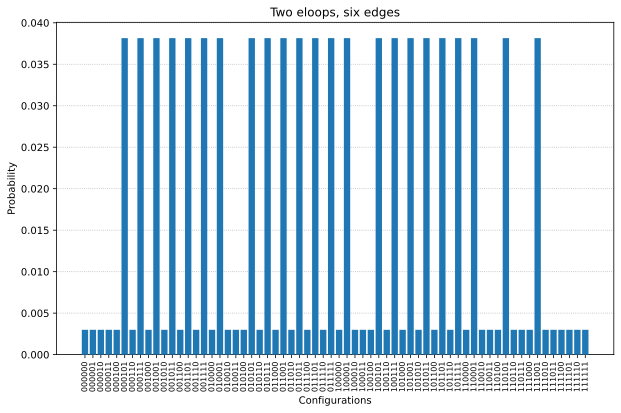

CPU times: total: 359 ms
Wall time: 453 ms


In [20]:
%%time

qanalysis.plot_histogram()

In [21]:
%%time

print("Number of causal configurations detected:", qanalysis.get_num_causal_configurations())

Number of causal configurations detected: 23
CPU times: total: 0 ns
Wall time: 1 ms


# Comparison with BSS

## Computation not possible - I've let it run for 1h50min and still DNF

In [ ]:
# %%time

# qcirc.revert_master_phases(qcirc.t_repr_graph)

# print("T-Gate Representation Graph")
# nice_draw(qcirc.t_repr_graph)

# g = qcirc.t_repr_graph.copy()

# zx.draw(g, scale=20, labels=True)
# print("T-count = ", zx.tcount(g))

# zx.simplify.full_reduce(g)

# zx.draw(g, scale=20, labels=True)
# print("T-count = ", zx.tcount(g))
# gT = zx.tcount(g)

# gDecomp = zx.simulate.find_stabilizer_decomp(g)
# print("\nExact:   ",len(gDecomp))
# print("Estimate:",7**(gT/6))

# g = h.copy()

# Application to "Four-eloop topology with eight edges"

## Circuit creation

In [24]:
%%time

# Nomenclature taken from paper
E_CNT = 12
A_CNT = 9
OUT_CNT = 1 # always has to be zero but just to make it be clean

left_cnot_pos = []
right_cnot_pos = []
mid_toffoli_pos = 0

print("------------------------------------ Initial circuit creation ------------------------------------")

qcirc = QCirc(E_CNT, A_CNT, OUT_CNT)
qcirc.add_toffoli_gates_IS([0,1,2,3,4,5,6,7], E_CNT+0)
qcirc.add_not_gates_IS([6,7,11])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([4,5,10,11], E_CNT+3)
qcirc.add_toffoli_gates_IS([2,3,4,5,9,11], E_CNT+6)
qcirc.add_not_gates_IS([4,5,10])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([2,3,9,10], E_CNT+2)
qcirc.add_toffoli_gates_IS([0,1,2,3,8,10], E_CNT+5)
qcirc.add_not_gates_IS([2,3,9])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([0,1,8,9], E_CNT+1)
qcirc.add_not_gates_IS([0,1])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([0,1,2,3,4,5,6,7], E_CNT+0)
qcirc.add_toffoli_gates_IS([6,7,8,11], E_CNT+4)
qcirc.add_toffoli_gates_IS([4,5,6,7,8,10], E_CNT+7)
qcirc.add_not_gates_IS([6,7,8,11])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([4,5,10,11], E_CNT+3)
qcirc.add_toffoli_gates_IS([2,3,4,5,9,11], E_CNT+6)
qcirc.add_not_gates_IS([4,5,10])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([2,3,9,10], E_CNT+2)
qcirc.add_toffoli_gates_IS([0,1,2,3,8,10], E_CNT+5)
qcirc.add_not_gates_IS([9])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([0,1,8,9], E_CNT+1)
qcirc.add_not_gates_IS([0,1])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([6,7,8,11], E_CNT+4)
qcirc.add_not_gates_IS([9])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([4,5,6,7,8,10], E_CNT+7)
qcirc.add_toffoli_gates_IS([0,1,6,7,9,11], E_CNT+8)
qcirc.add_not_gates_IS([0,1,6,7,9,11])
left_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([0,1,6,7,9,11], E_CNT+8)

mid_toffoli_ctrls = [0,E_CNT+0, E_CNT+1, E_CNT+2, E_CNT+3, E_CNT+4, E_CNT+5, E_CNT+6, E_CNT+7, E_CNT+8]
mid_toffoli_main_ctrl = E_CNT+A_CNT+0
qcirc.add_toffoli_gates_IS(mid_toffoli_ctrls, mid_toffoli_main_ctrl, False)
mid_toffoli_pos = len(qcirc.init_subgraphs)-2
left_cnot_pos.append(mid_toffoli_pos-1)
right_cnot_pos.append(mid_toffoli_pos+1)

qcirc.add_toffoli_gates_IS([0,1,6,7,9,11], E_CNT+8)
qcirc.add_not_gates_IS([0,1,6,7,9,11])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([0,1,6,7,9,11], E_CNT+8)
qcirc.add_not_gates_IS([0,1,9])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([4,5,6,7,8,10], E_CNT+7)
qcirc.add_toffoli_gates_IS([0,1,8,9], E_CNT+1)
qcirc.add_toffoli_gates_IS([6,7,8,11], E_CNT+4)
qcirc.add_not_gates_IS([4,5,6,7,9])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([2,3,9,10], E_CNT+2)
qcirc.add_toffoli_gates_IS([0,1,2,3,8,10], E_CNT+5)
qcirc.add_not_gates_IS([8,10])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([4,5,10,11], E_CNT+3)
qcirc.add_toffoli_gates_IS([2,3,4,5,9,11], E_CNT+6)
qcirc.add_not_gates_IS([11])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([0,1,2,3,4,5,6,7], E_CNT+0)
qcirc.add_not_gates_IS([0,1,2,3])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([6,7,8,11], E_CNT+4)
qcirc.add_toffoli_gates_IS([4,5,6,7,8,10], E_CNT+7)
qcirc.add_not_gates_IS([4,5,6,7])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([0,1,8,9], E_CNT+1)
qcirc.add_not_gates_IS([9])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([2,3,9,10], E_CNT+2)
qcirc.add_toffoli_gates_IS([0,1,2,3,8,10], E_CNT+5)
qcirc.add_not_gates_IS([10])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([4,5,10,11], E_CNT+3)
qcirc.add_toffoli_gates_IS([2,3,4,5,9,11], E_CNT+6)
qcirc.add_not_gates_IS([11])
right_cnot_pos.append(len(qcirc.init_subgraphs)-1)
qcirc.add_toffoli_gates_IS([0,1,2,3,4,5,6,7], E_CNT+0)

# qcirc.apply_diffusion_operator_IS()

nice_draw(qcirc.get_merged_IS())

# qcirc.set_orig_statevec()

------------------------------------ Initial circuit creation ------------------------------------
	sqrt(2)^0 ≈ (1+0j)


CPU times: total: 266 ms
Wall time: 638 ms


## Applying Algorithm

In [25]:
%%time

qalgo = QAlgo(qcirc, left_cnot_pos, right_cnot_pos, mid_toffoli_pos, mid_toffoli_ctrls, mid_toffoli_main_ctrl)
cliffs = qalgo.run(show_diagrams=True, check_decomposition=False)

[This computation cannot be done in polynomial time]

------------------------------------ ALGO STEP 1: Pushing all NOT gates to the sides without crossing the middle ------------------------------------
	sqrt(2)^0 ≈ (1+0j)



------------------------------------ ALGO STEP 2: Change from IS to non_cliffs representation ------------------------------------
non_cliff no. 0
	sqrt(2)^0 ≈ (1+0j)



------------------------------------ ALGO STEP 3: Create two stacks (stack1 -> 2 NOTs | stack2 -> 1 NOT) for each of the summands ------------------------------------
non_cliff no. 0
left_row_bound: 12
right_row_bound: 212.0
left_bounds: [49, 50, 51, 52, 54, 55, 57, 58, 47, 53, 56, 59]
right_bounds: [1469, 1470, 1471, 1472, 1465, 1466, 1467, 1468, 1474, 1464, 1463, 1462]
z_nodes: [60, 61, 62, 63, 64, 65, 66, 67, 111, 112, 113, 114, 143, 144, 145, 146, 147, 148, 185, 186, 187, 188, 214, 215, 216, 217, 218, 219, 253, 254, 255, 256, 282, 283, 284, 285, 286, 287, 288, 289, 335, 336, 337, 338, 366, 367, 368, 369, 370, 371, 406, 407, 408, 409, 434, 435, 436, 437, 438, 439, 474, 475, 476, 477, 505, 506, 507, 508, 509, 510, 548, 549, 550, 551, 579, 580, 581, 582, 608, 609, 610, 611, 612, 613, 650, 651, 652, 653, 654, 655, 689, 690, 691, 692, 693, 694, 732, 790, 791, 792, 793, 794, 795, 833, 834, 835, 836, 837, 838, 872, 873, 874, 875, 876, 877, 914, 915, 916, 917, 945, 946, 947, 948, 974, 975


------------------------------------ ALGO STEP 4: Substitute star structure (Triangle + NOT) with Z Spider with placeholder phase ------------------------------------
non_cliff no. 0
	sqrt(2)^0 ≈ (1+0j)



------------------------------------ ALGO STEP 5: Apply effects that will later be used for simulation and now can already help with cancellation ------------------------------------
non_cliff no. 0
	sqrt(2)^0 ≈ (1+0j)



------------------------------------ ALGO STEP 6: Push all states and effects (with E register states excluded (left side)) ------------------------------------
non_cliff no. 0
	sqrt(2)^-1 ≈ (0.7071067811865475+0j)



------------------------------------ ALGO STEP 7: Recursive decomposition algorithm ------------------------------------
NOTE: The following number may be less due to zero-scalars - See analysis section
Number of terms in found decomposition: 974
CPU times: total: 2.06 s
Wall time: 2.7 s


In [26]:
%%time

qanalysis = QAnalysis(qcirc, cliffs, zero_scalar_removal_rtol=1e-5, zero_scalar_removal_atol=1e-8)
qanalysis.simplify_qalgo_result(draw_cliffs=False)

[This computation can be done in polynomial time]
CPU times: total: 703 ms
Wall time: 903 ms


In [27]:
%%time

qanalysis.apply_diff_op_on_all_cliffs(draw_initial_cliffs=False, draw_processed_cliffs=False, check_decomp=False)

[This computation cannot be done in polynomial time]
Removed/skipped 0 diagrams with approx. zero scalar (rtol=1e-05, atol=1e-08) during this step
Resulting number of terms in found decomposition (final simplification still outstanding): 1948
CPU times: total: 15.2 s
Wall time: 15.8 s


In [28]:
%%time

qanalysis.set_final_statevec_to_sum_of_diagrams(qanalysis.diff_op_applied_cliffs, draw_final_cliffs=False, print_final_statevec=True)

[This computation can be done in polynomial time]
Removed 0 diagrams with approx. zero scalar (rtol=1e-05, atol=1e-08) during this step
Final number of terms in found decomposition (diffusion operator applied, zero-scalars removed): 1948
Final Statevector:
[ 0.00267029+0.j  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j
  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j
  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j
  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j
 -0.02857971+0.j  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j
  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j
 -0.02857971+0.j  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j
 -0.02857971+0.j  0.00267029+0.j -0.02857971+0.j -0.02857971+0.j
 -0.02857971+0.j  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j
  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j
 -0.02857971+0.j  0.00267029+0.j  0.00267029+0.j  0.00267029+0.j
 -0.02857971+0.j  0.00267029

In [29]:
%%time

print("Number of causal configurations detected:", qanalysis.get_num_causal_configurations())

Number of causal configurations detected: 1199
CPU times: total: 0 ns
Wall time: 6.02 ms
